<a href="https://colab.research.google.com/github/wendycao411/Pedestrian_Tracking/blob/main/Pedestrian_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedestrian Tracking

created by wendycao 2025/1

best if run with T4 GPU (A100 GPU if Colab Pro)! it'll be much faster. to change GPU, go to the runtime tab and select "change runtime type".

#### Installing dependencies

In [ ]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install ultralytics
%pip install roboflow
%pip install matplotlib
%pip install os-sys
%pip install roboflow
%pip install inference_sdk
%pip install easydict

%pip install lap

  Using cached os_sys-2.1.4-py3-none-any.whl.metadata (9.9 kB)
  Using cached pygubu-0.36.1-py3-none-any.whl.metadata (7.2 kB)
  Using cached progress-1.6.tar.gz (7.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached progressbar-2.5.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached eel-0.18.1.tar.gz (26 kB)
  Preparing metadata (setup.py) ... done
  Using cached extract_zip-1.0.0-py3-none-any.whl.metadata (403 bytes)
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
  Using cached os_sys-2.1.3-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-2.1.2-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-2.1.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-2.1.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-2.0.9-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-

In [ ]:
%pip uninstall numpy -y
%pip install "numpy<1.24"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.35.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
numb

In [ ]:
import cv2
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
from inference_sdk import InferenceHTTPClient

from collections import defaultdict

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

from roboflow import Roboflow

from IPython.display import Image, display

import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(if it asks to restart the runtime, click restart session and then re-run the cell importing modules)

#### Download Videos from Google Drive (requires the download link)

*How to generate the download link:*


1.   Get the "Share Link" for the video (make sure anyone can view the video!) - e.g. https://drive.google.com/file/d/1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q/view?usp=drive_link
2.   Get the ID for the video, which is in between the /d/ and /view - e.g. 1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q
3.   Paste the ID in this link: https://drive.google.com/uc?id=(ID HERE)&export=download -- e.g. https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&export=download
4.   Done!



In [ ]:
!gdown https://drive.google.com/uc?id=18rPsyqowHNcFL9sJbPSYwTf5N1vMJ79F&export=download


Downloading...
From (original): https://drive.google.com/uc?id=18rPsyqowHNcFL9sJbPSYwTf5N1vMJ79F
From (redirected): https://drive.google.com/uc?id=18rPsyqowHNcFL9sJbPSYwTf5N1vMJ79F&confirm=t&uuid=28e38185-ba08-4880-a26f-c97339bbad75
To: /content/Kabukicho_240825.mov
100% 597M/597M [00:07<00:00, 84.5MB/s]


#### Preprocessing

In [ ]:
video_path = "/content/Kabukicho_240825.mov"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(file_name)

Kabukicho_240825


In [ ]:
# video preprocessing

# option 1 Adjust the frame rate to 5 FPS, and the total duration remains unchanged
#ffmpeg -i "/content/2022-07-31.mp4" -r 5 "/content/2022-07-31_5fps.mp4"

#USE ON LARGER VIDEOS
# option 2 function: subsample/time lapse video
def subsample_video(input_path, output_path, time_lapse_interval):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Couldn't open video file.")
        return

    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    codec = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, codec, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Collect one frame out of every xx frames
        if frame_count % time_lapse_interval == 0:
            out.write(frame)

        frame_count += 1

    cap.release()
    out.release()
    #cv2.destroyAllWindows()

if __name__ == "__main__":
    time_lapse_interval = 5 # change here
    input_file = video_path
    output_file = f"/content/{file_name}_timelapsed{time_lapse_interval}.mp4"  # Replace with desired output video file path
    subsample_video(input_file, output_file, time_lapse_interval)
    print(f"saved to {output_file}")

saved to /content/Kabukicho_240825_timelapsed5.mp4


In [ ]:
video_path = "/content/Kabukicho_240825_timelapsed5.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(video_path)
print(file_name)

/content/Kabukicho_240825_timelapsed5.mp4
Kabukicho_240825_timelapsed5


In [ ]:
# number of frames in the video
cap = cv2.VideoCapture(video_path)

# Get the file name
file_name = os.path.splitext(os.path.basename(video_path))[0]

# Get the total number of frames of the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
original_fps = cap.get(cv2.CAP_PROP_FPS)

print(f"The total number of frames in the video：{total_frames}\nVideo frame rate：{original_fps}")
cap.release()

The total number of frames in the video：868
Video frame rate：59.93


#### Download the Model!

can also download elsewhere and upload to get other models and test if they are better

In [ ]:
#!gdown https://drive.google.com/uc?id=19ZYplT-m0SaXrJXks9DhO7wdIUMpK2_F&export=download

#used by Emma, not tested if more accurate yet but is slower
#!gdown https://drive.google.com/uc?id=1WFUfBKAB2_U96PwHiI08seJzKk3yeGLg&export=download

#another model to test with (the most recent and accurate?? one)
!gdown https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S
From (redirected): https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S&confirm=t&uuid=4d78486a-768f-401d-beda-fef1edd52abd
To: /content/yolo11x-seg.pt
100% 125M/125M [00:02<00:00, 62.5MB/s]


#### To implement the DeepSORT tracking, downloading the required files (only needs to be done once at the beginnning of running the code)

In [ ]:
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t
To: /content/deep_sort_pytorch.zip
100% 43.1M/43.1M [00:00<00:00, 66.7MB/s]


In [ ]:
!unzip 'deep_sort_pytorch.zip'

Archive:  deep_sort_pytorch.zip
  inflating: deep_sort_pytorch/.gitignore  
   creating: deep_sort_pytorch/configs/
  inflating: deep_sort_pytorch/configs/deep_sort.yaml  
   creating: deep_sort_pytorch/deep_sort/
  inflating: deep_sort_pytorch/deep_sort/__init__.py  
   creating: deep_sort_pytorch/deep_sort/__pycache__/
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-38.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-38.pyc  
   creating: deep_sort_pytorch/deep_sort/deep/
 extracting: deep_sort_pytorch/deep_sort/deep/__init__.py  
   creating: deep_sort_pytorch/deep_sort/deep/__pycache__/
  inflating: deep_sort_pytorch/d

#### Run the Script for Segmentation with DeepSORT Tracking

In [ ]:
from deep_sort_pytorch.utils.parser import get_config
from deep_sort_pytorch.deep_sort import DeepSort
from collections import deque

In [ ]:
# Set parameters
skip = 2
output_dir = "output"

# Function to initialize the DeepSORT tracker
def init_tracker():
    cfg = get_config()
    cfg.merge_from_file("deep_sort_pytorch/configs/deep_sort.yaml")

    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    return deepsort

# Load the YOLO model for person detection
model_person = YOLO("/content/yolo11x-seg.pt").to("cuda")  # Ensure this is your correct device

# Initialize Roboflow client for shadow detection
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key="2nHLYGbdwz0EHlteoHxo")

# Create a subfolder for each video in the output directory
video_output_dir = os.path.join(output_dir, file_name)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)

output_video_path = os.path.join(video_output_dir, f"{file_name}_human-and-shade-tracking.avi")
csv_file = os.path.join(video_output_dir, f"{file_name}_detections.csv")

# Initialize the DeepSORT tracker
deepsort = init_tracker()

# Dictionary to store trails
trails = {}

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

# Initialize CSV file with headers
csv_headers = ['frame', 'person_id', 'bottom_mid_x', 'bottom_mid_y', 'in_shadow', 'shadow_area', 'proportion_of_shade']
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_headers)

frame_count = 0
consecutive_person_id = 0
person_id_mapping = {}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    frame_count += 1

    if frame_count % skip == 0:
        print(f"Processing frame {frame_count}/{total_frames}")  # Display progress

        shadow_result = CLIENT.infer(frame, model_id="shade-detection/6")
        boundaries = []

        if 'predictions' in shadow_result:
            predictions = shadow_result['predictions']
            for prediction in predictions:
                points = prediction.get("points", [])
                if points:
                    boundary = [(int(point['x']), int(point['y'])) for point in points]
                    boundaries.append(boundary)

        annotator = Annotator(frame, line_width=2)
        people_in_shadow = 0
        people_outside_shadow = 0
        total_people = 0
        detections = []

        shade_area = 0
        # Draw the shadow polygon
        for boundary in boundaries:
            boundary_points = np.array(boundary, np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [boundary_points], isClosed=True, color=(255, 0, 0), thickness=2)
            shade_area = cv2.contourArea(boundary_points)

        # Calculate the proportion of shade
        frame_area = w * h
        proportion_of_shade = shade_area / frame_area if frame_area > 0 else 0

        # People detection
        person_results = model_person(frame, classes=[0], conf=0.05, show=False)
        if person_results and len(person_results) > 0:
            boxes = person_results[0].boxes

            if boxes and len(boxes) > 0:
                xyxy = boxes.xyxy.cpu().numpy()
                confidences = boxes.conf.cpu().numpy()
                oids = boxes.cls.cpu().numpy()

                # Convert to the format expected by DeepSORT
                bbox_xywh = []
                for box in xyxy:
                    x1, y1, x2, y2 = box
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1
                    bbox_xywh.append([xc, yc, w, h])

                bbox_xywh = np.array(bbox_xywh)

                # Update DeepSORT tracker with detected boxes
                outputs = deepsort.update(bbox_xywh, confidences, oids, frame)

                for output in outputs:
                    x1, y1, x2, y2, track_id, track_oid = output
                    bottom_mid_x = int((x1 + x2) // 2)
                    bottom_mid_y = int(y2)
                    in_shadow = False

                    # Map the original track_id to consecutive_person_id
                    if track_id not in person_id_mapping:
                        person_id_mapping[track_id] = consecutive_person_id
                        consecutive_person_id += 1

                    # Use the mapped consecutive_person_id
                    person_id = person_id_mapping[track_id]

                    for boundary in boundaries:
                        if cv2.pointPolygonTest(np.array(boundary, np.int32), (bottom_mid_x, bottom_mid_y), False) >= 0:
                            in_shadow = True
                            people_in_shadow += 1
                            break
                    else:
                        people_outside_shadow += 1

                    detections.append([frame_count, person_id, bottom_mid_x, bottom_mid_y, in_shadow, shade_area, proportion_of_shade])
                    total_people += 1

                    # Store the position for trails
                    if track_id not in trails:
                        trails[track_id] = deque(maxlen=30)
                    trails[track_id].append((bottom_mid_x, bottom_mid_y))

                    # Draw the trails
                    for i in range(1, len(trails[track_id])):
                        if trails[track_id][i - 1] is None or trails[track_id][i] is None:
                            continue
                        cv2.line(frame, trails[track_id][i - 1], trails[track_id][i], (0, 255, 0), 2)

                    color = (0, 255, 0)  # You can use your colors function if defined
                    label = f"ID {person_id} {'in shadow' if in_shadow else 'out shadow'}"
                    annotator.box_label([x1, y1, x2, y2], label=label, color=color)
                    cv2.circle(frame, (bottom_mid_x, bottom_mid_y), 5, (0, 0, 255), -1)

        # Write the results to CSV
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(detections)

        # Display the statistics results on the frame
        text = f"Frame {frame_count}: Total: {total_people}, In Shadow: {people_in_shadow}, Outside Shadow: {people_outside_shadow}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Write the original frame
        out.write(frame)

        #COMMENT OUT IF ON COLAB, but can display progress
        #cv2_imshow("instance-segmentation-object-tracking", frame)  # Display the frame using cv2_imshow
        #if cv2.waitKey(1) & 0xFF == ord("q"):
        #    break

cap.release()
out.release()

print(f"Processing complete. Results saved in {output_video_path} and {csv_file}.")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Data Analysis

#### Creating a document to store all graphs

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

csv_file = "/content/2024-07-23_timelapsed5_detections.csv"
csv_dir = os.path.dirname(csv_file)

# Create a PDF document
pdf_file = os.path.join(csv_dir, "all_plots.pdf")
pdf = PdfPages(pdf_file)

#### Count of People

In [ ]:
import pandas as pd

# Load the CSV file
data = pd.read_csv(csv_file)

# Initialize dictionaries to count the number of people in and out of shadow for each frame
num_in_shadow = {}
num_out_shadow = {}

# Count the number of people in and out of shadow for each frame
for frame in data['frame'].unique():
    count_in_shadow = len(data[(data['in_shadow'] == True) & (data['frame'] == frame)])
    count_out_shadow = len(data[(data['in_shadow'] == False) & (data['frame'] == frame)])
    num_in_shadow[frame] = count_in_shadow
    num_out_shadow[frame] = count_out_shadow

# Create a new DataFrame from the counts
count_df = pd.DataFrame({
    'Frame': num_in_shadow.keys(),
    'in_shadow': num_in_shadow.values(),
    'out_shadow': num_out_shadow.values()
})

print(count_df)
print(data)

      Frame  in_shadow  out_shadow
0         6          1          10
1         8          0          11
2        10          0          11
3        12          0          12
4        14          0          12
...     ...        ...         ...
7658  15322          4           3
7659  15324          5           3
7660  15326          4           3
7661  15328          5           2
7662  15330          5           2

[7663 rows x 3 columns]
       frame  person_id  bottom_mid_x  bottom_mid_y  in_shadow  shadow_area
0          6          0           862          1067      False       7111.5
1          6          1          1804           814       True       7111.5
2          6          2           798           813      False       7111.5
3          6          3           761          1047      False       7111.5
4          6          4          1318           960      False       7111.5
...      ...        ...           ...           ...        ...          ...
59975  15330        679

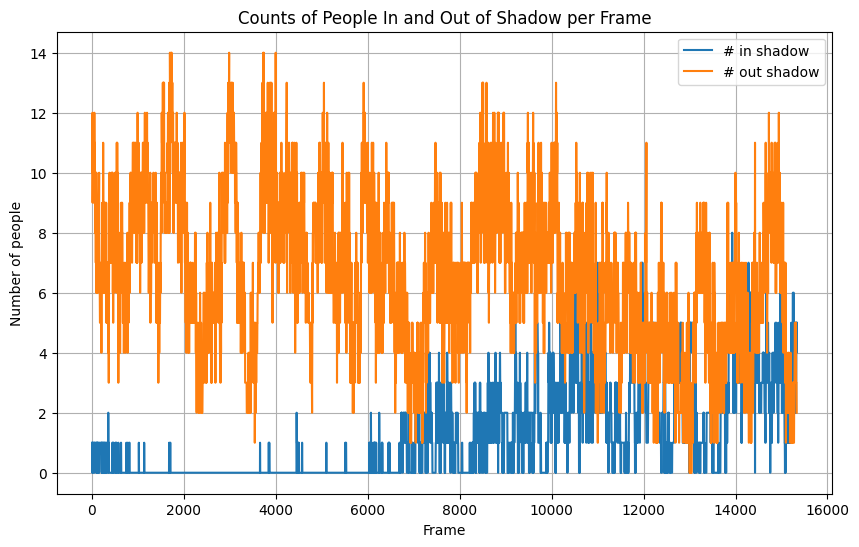

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df['Frame'], count_df['in_shadow'], label='# in shadow')
ax.plot(count_df['Frame'], count_df['out_shadow'], label='# out shadow')
ax.legend()

ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
ax.set_title("Counts of People In and Out of Shadow per Frame")
ax.grid(True)

pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Moving Average

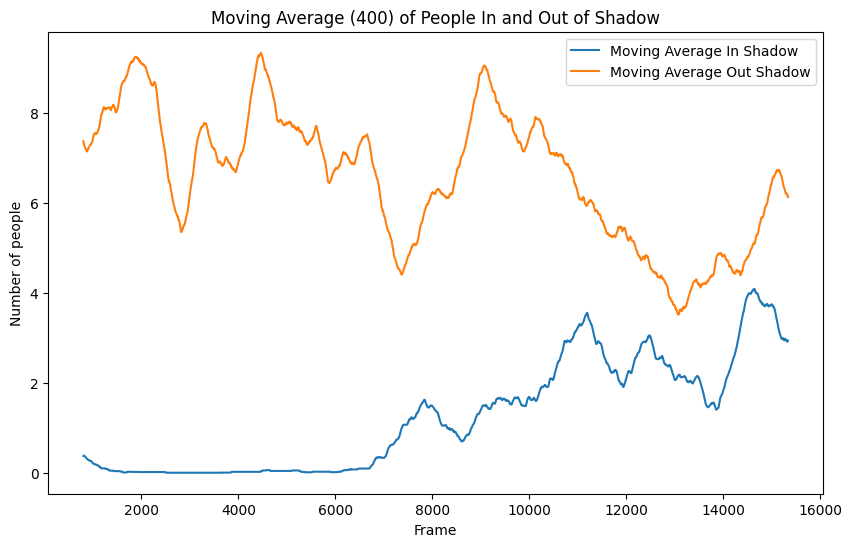

In [ ]:
# Calculate the moving average for 'out_shadow' and 'in_shadow'
window_size = 400
count_df['ma_out_shadow'] = count_df['out_shadow'].rolling(window=window_size).mean()
count_df['ma_in_shadow'] = count_df['in_shadow'].rolling(window=window_size).mean()

# Plot the moving averages
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df['Frame'], count_df['ma_in_shadow'], label='Moving Average In Shadow')
ax.plot(count_df['Frame'], count_df['ma_out_shadow'], label='Moving Average Out Shadow')
ax.legend()
ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
ax.set_title(f'Moving Average ({window_size}) of People In and Out of Shadow')

pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Shade Evolution

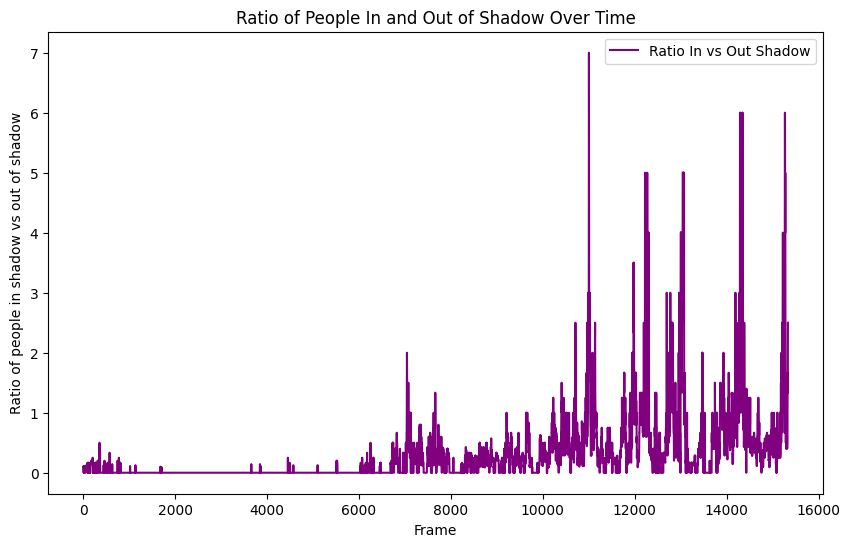

In [ ]:
# Calculate the ratio of people in shade vs. out of shade
count_df['ratio_in_vs_out'] = count_df['in_shadow'] / count_df['out_shadow']

# Replace NaN values with zeros (or another value if appropriate)
count_df['ratio_in_vs_out'] = count_df['ratio_in_vs_out'].fillna(0)

# Plot the ratio
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df['Frame'], count_df['ratio_in_vs_out'], label='Ratio In vs Out Shadow', color='purple')
ax.set_xlabel('Frame')
ax.set_ylabel('Ratio of people in shadow vs out of shadow')
ax.set_title('Ratio of People In and Out of Shadow Over Time')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




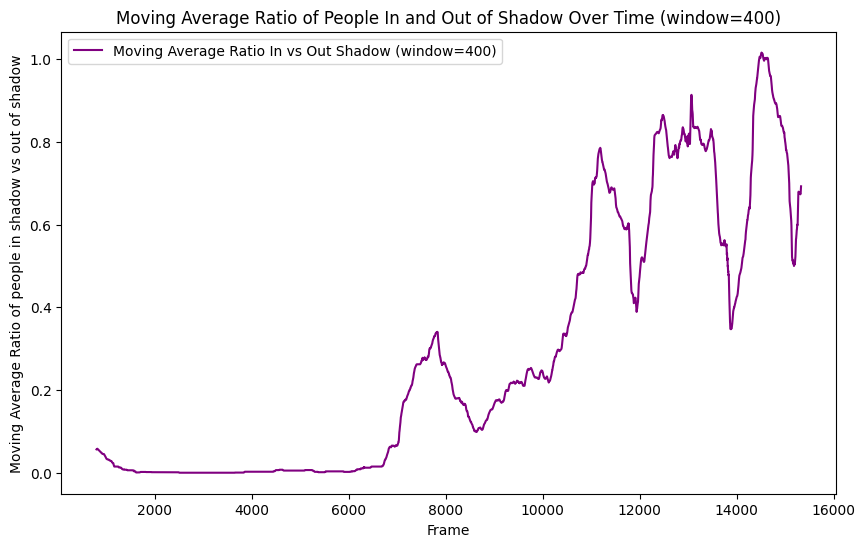

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
# Calculate the ratio of people in shade vs. out of shade
count_df['ratio_in_vs_out'] = count_df['in_shadow'] / count_df['out_shadow']

# Replace NaN and infinite values with zeros (or another value if appropriate)
count_df['ratio_in_vs_out'].replace([np.inf, -np.inf], np.nan, inplace=True)
count_df['ratio_in_vs_out'] = count_df['ratio_in_vs_out'].fillna(0)

# Calculate the moving average for the ratio
window_size = 400
count_df['ma_ratio_in_vs_out'] = count_df['ratio_in_vs_out'].rolling(window=window_size).mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df['Frame'], count_df['ma_ratio_in_vs_out'], label=f'Moving Average Ratio In vs Out Shadow (window={window_size})', color='purple')
ax.set_xlabel('Frame')
ax.set_ylabel('Moving Average Ratio of people in shadow vs out of shadow')
ax.set_title(f'Moving Average Ratio of People In and Out of Shadow Over Time (window={window_size})')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

print

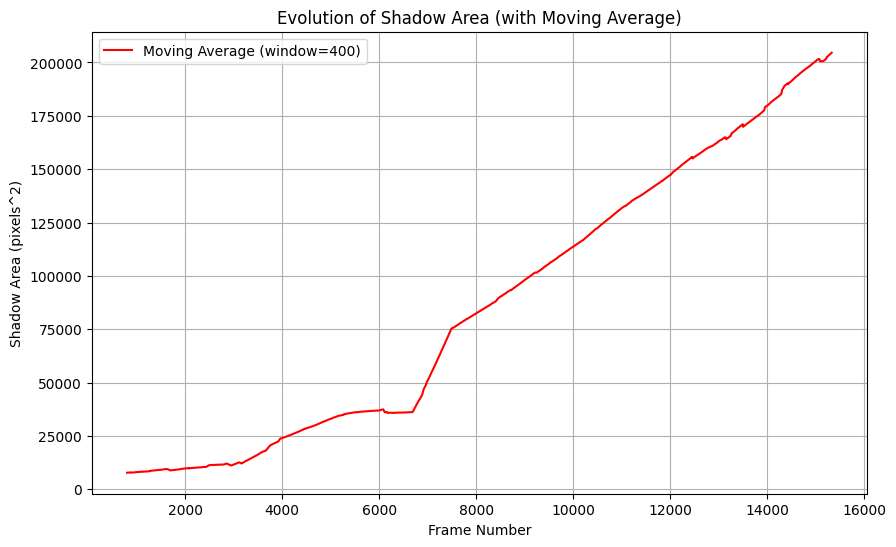

       frame  person_id  bottom_mid_x  bottom_mid_y  in_shadow  shadow_area
0          6          0           862          1067      False       7111.5
1          6          1          1804           814       True       7111.5
2          6          2           798           813      False       7111.5
3          6          3           761          1047      False       7111.5
4          6          4          1318           960      False       7111.5
...      ...        ...           ...           ...        ...          ...
59975  15330        679          1651           655       True     213267.0
59976  15330        681          1701           613       True     213267.0
59977  15330        682          1615          1065      False     213267.0
59978  15330        684          1367           820       True     213267.0
59979  15330        685          1518           881       True     213267.0

[59980 rows x 6 columns]


In [ ]:
# Extract the 'frame' and 'shade_area' columns
shade_data = data[['frame', 'shadow_area']]

# Remove duplicate rows
shade_data = shade_data.drop_duplicates()

# Sort the data by 'frame' to ensure the plot is in the correct order
shade_data = shade_data.sort_values(by='frame')

# Calculate the moving average with a window size of your choice (e.g., 5 frames)
window_size = 400
shade_data['shadow_area_moving_avg'] = shade_data['shadow_area'].rolling(window=window_size).mean()

# Plot the original shade area and its moving average
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(data['frame'], data['shadow_area'], marker='o', linestyle='-', color='b', label='Shade Area')
ax.plot(shade_data['frame'], shade_data['shadow_area_moving_avg'], marker='', linestyle='-', color='r', label=f'Moving Average (window={window_size})')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Shadow Area (pixels^2)')
ax.set_title('Evolution of Shadow Area (with Moving Average)')
ax.legend()
ax.grid(True)

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

print(data)

#### Overlaying Graphs

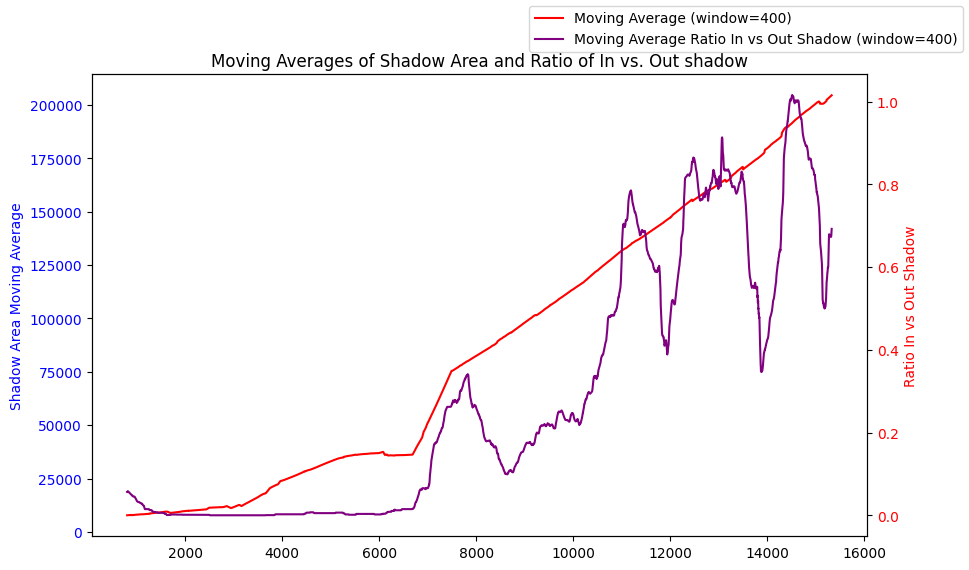

In [ ]:
# axes

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(shade_data['frame'], shade_data['shadow_area_moving_avg'], marker='', linestyle='-', color='r', label=f'Moving Average (window={window_size})')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('Shadow Area Moving Average', color='b')

ax2 = ax1.twinx()

ax2.plot(count_df['Frame'], count_df['ma_ratio_in_vs_out'], label=f'Moving Average Ratio In vs Out Shadow (window={window_size})', color='purple')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Ratio In vs Out Shadow', color='r')

fig.legend(loc='upper right')
plt.title('Moving Averages of Shadow Area and Ratio of In vs. Out shadow')

pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Shade Index Calculations

In [ ]:
import cv2
import numpy as np

# function to calculate polygon area using shoelace formula
def calculate_area(points):
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# scale and normalize the area
def normalize_area(area, original_size, target_size):
    scale_factor = (target_size[0] / original_size[0]) * (target_size[1] / original_size[1])
    return area * scale_factor

# original image points
points = np.array([
    [2193, 586],
    [2448, 630],
    [332, 1349],
    [2356, 1336]
], dtype='float32')

original_size = (2561, 1433)  # original video size

video = '/content/2024-07-23.mp4'

# get the frame dimensions
video_width = 1920
video_height = 1068

print(video_width, video_height)

target_size = (video_width, video_height)

area = calculate_area(points)
normalized_area = normalize_area(area, original_size, target_size)

print(f"Original Area: {area}")
print(f"Normalized Area: {normalized_area}")

shade_data['proportion'] = shade_data['shadow_area'] / normalized_area
print(shade_data)
print(count_df)


1920 1068
Original Area: 621835.0
Normalized Area: 347449.64733496413
       frame  shadow_area  shadow_area_moving_avg  proportion
0          6       7111.5                     NaN    0.020468
11         8       7101.0                     NaN    0.020437
22        10       7098.0                     NaN    0.020429
33        12       7153.5                     NaN    0.020589
45        14       7179.0                     NaN    0.020662
...      ...          ...                     ...         ...
59944  15322     216784.5            204407.08875    0.623931
59951  15324     215898.0            204454.50375    0.621379
59959  15326     213247.5            204488.45250    0.613751
59966  15328     211426.5            204524.50125    0.608510
59973  15330     213267.0            204564.00375    0.613807

[7663 rows x 4 columns]
      Frame  in_shadow  out_shadow  ma_out_shadow  ma_in_shadow  \
0         6          1          10            NaN           NaN   
1         8          0     

#### NOT WORKING

In [ ]:
# Calculate the ratio of people to proportion of shade
count_df['ratio_to_proportion'] = count_df["ratio_in_vs_out"] / shade_data['proportion']
count_df.head()

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df['Frame'], count_df['ratio_to_proportion'], label=f'Ratio of People to Proportion of Shade', color='purple')
ax.set_xlabel('Frame')
ax.set_ylabel('Ratio of People to Proportion of Shade')
ax.set_title('Ratio of People In and Out of Shade vs. Proportion of Shade')
ax.legend()

# Save the current plot to the PDF

plt.show()


In [ ]:
output_dir = "output"
video_output_dir = "/content"
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)

# Save the filtered data to a new CSV file in the subfolder
shade_area_file = os.path.join(video_output_dir, 'shade_area.csv')
shade_data.to_csv(shade_area_file, index=False)

print(f"Shade data saved to {shade_area_file}")

Shade data saved to /content/shade_area.csv


In [ ]:
print(data)

       frame  person_id  bottom_mid_x  bottom_mid_y  in_shadow  shadow_area
0          6          0           862          1067      False       7111.5
1          6          1          1804           814       True       7111.5
2          6          2           798           813      False       7111.5
3          6          3           761          1047      False       7111.5
4          6          4          1318           960      False       7111.5
...      ...        ...           ...           ...        ...          ...
59975  15330        679          1651           655       True     213267.0
59976  15330        681          1701           613       True     213267.0
59977  15330        682          1615          1065      False     213267.0
59978  15330        684          1367           820       True     213267.0
59979  15330        685          1518           881       True     213267.0

[59980 rows x 6 columns]


#### Geocoordinates - download TIF

not accurate yet (if you plot the geocoordinates, they form a graph with the same perspective as the image, and it should be expected to form a rectangular shape like the TIF)

In [ ]:
!gdown https://drive.google.com/uc?id=119tkpmy3u13tydRT83xoKgXY2trbX8Fk&export=download

Downloading...
From: https://drive.google.com/uc?id=119tkpmy3u13tydRT83xoKgXY2trbX8Fk
To: /content/streetview.tif
100% 30.0M/30.0M [00:00<00:00, 92.9MB/s]


In [ ]:
from osgeo import gdal
import pandas as pd

def pixel_to_latlon(tif_file, pixel_x, pixel_y, img_width, img_height):
    dataset = gdal.Open(tif_file)
    geotransform = dataset.GetGeoTransform()

    # Normalize pixel coordinates
    norm_pixel_x = pixel_x / img_width
    norm_pixel_y = pixel_y / img_height

    # Get the origin coordinates
    x_origin = geotransform[0]
    y_origin = geotransform[3]

    # Get the pixel size
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    # Calculate the latitude and longitude
    lat = y_origin + norm_pixel_y * img_height * pixel_height
    lon = x_origin + norm_pixel_x * img_width * pixel_width

    return lat, lon

video = cv2.VideoCapture("/content/2024-07-23.mp4")

# Get the frame dimensions
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Iterate through each row in the CSV
geo_coords = data.apply(
    lambda row: pixel_to_latlon('/content/streetview.tif', row['bottom_mid_x'], row['bottom_mid_y'], video_width, video_height), axis=1
)

# Split the geocoordinates into separate columns
data['latitude'] = geo_coords.apply(lambda coord: coord[0])
data['longitude'] = geo_coords.apply(lambda coord: coord[1])

# Save the transformed coordinates and geocoordinates to a new CSV file
# Save to a new CSV file
transformed_output_file = os.path.join(video_output_dir, 'geo_data.csv')
data.to_csv(transformed_output_file, index=False)

print(f"Transformed CSV saved to {transformed_output_file}")

KeyError: 'bottom_mid_x'

#### Filter

In [ ]:
# Load the csv
data = pd.read_csv(transformed_output_file)

# Define the minimum presence duration (in frames) to consider a track segment as valid
MIN_PRESENCE_DURATION = 30  # Adjust this based on your needs

# Define the maximum allowed displacement (in pixels)
MAX_DISPLACEMENT = 50  # Adjust this threshold based on your needs

# Define the maximum gap between frames to consider a continuous segment
MAX_FRAME_GAP = 100  # Adjust this threshold based on your needs

# Function to process each group
def process_group(x):
    # Extract the list of tuples
    coordinates_and_shadow = list(zip(x['frame'], x['bottom_mid_x'], x['bottom_mid_y'], x['in_shadow']))
    coordinates_and_shadow.sort(key=lambda t: t[0])

    geocoordinates_and_shadow = list(zip(x['frame'], x['latitude'], x['longitude'], x['in_shadow']))
    geocoordinates_and_shadow.sort(key=lambda t: t[0])

    # Identify valid segments
    valid_segments = []
    current_segment = [coordinates_and_shadow[0]]

    for i in range(1, len(coordinates_and_shadow)):
        # Calculate the displacement between consecutive frames
        displacement = np.sqrt((coordinates_and_shadow[i][1] - coordinates_and_shadow[i-1][1])**2 +
                               (coordinates_and_shadow[i][2] - coordinates_and_shadow[i-1][2])**2)

        frame_gap = coordinates_and_shadow[i][0] - coordinates_and_shadow[i-1][0]

        if frame_gap <= 2 and displacement <= MAX_DISPLACEMENT:
            current_segment.append(coordinates_and_shadow[i])
        else:
            if len(current_segment) >= MIN_PRESENCE_DURATION:
                valid_segments.append(current_segment)
            current_segment = [coordinates_and_shadow[i]]

        if frame_gap > MAX_FRAME_GAP:
            break

    # Add the last segment if it is valid
    if len(current_segment) >= MIN_PRESENCE_DURATION:
        valid_segments.append(current_segment)

    # Flatten valid segments into a single list
    valid_coordinates_and_shadow = [item for segment in valid_segments for item in segment]

    # Extract start frame, end frame, and in_shadow statuses
    start_frame = valid_coordinates_and_shadow[0][0] if valid_coordinates_and_shadow else None
    end_frame = valid_coordinates_and_shadow[-1][0] if valid_coordinates_and_shadow else None
    in_shadow_statuses = [status for _, _, _, status in valid_coordinates_and_shadow]

    # Calculate the number of frames they are present in
    frames_present = len(valid_coordinates_and_shadow)
    seconds_present = frames_present * 2 / 5  # Since we have 5fps and skip every other frame

    return start_frame, end_frame, in_shadow_statuses, valid_coordinates_and_shadow, geocoordinates_and_shadow, frames_present, seconds_present

# Group data by person_id and apply the process_group function
grouped_data = data.groupby('person_id').apply(process_group).reset_index()

# Split the result into separate columns
grouped_data[['start_frame', 'end_frame', 'in_shadow_statuses', 'coordinates_and_shadow', 'geocoordinates_and_shadow', 'frames_present', 'seconds_present']] = pd.DataFrame(grouped_data[0].tolist(), index=grouped_data.index)
grouped_data = grouped_data.drop(columns=[0])

# Filter out tracks with no valid segments
filtered_data = grouped_data[grouped_data['frames_present'] > 0]

# Display the filtered data
print(filtered_data)

#### Categorizing

In [ ]:
def categorize_person(data, buffer_frames=10):
    # Extract in_shadow status
    in_shadow_status = [frame[3] for frame in data]

    # Apply buffer
    in_shadow_buffered = []
    buffer_count = 0
    for status in in_shadow_status:
        if status:
            buffer_count = buffer_frames  # Reset buffer
        elif buffer_count > 0:
            status = True
            buffer_count -= 1
        in_shadow_buffered.append(status)

    # Calculate the percentage of buffered frames in the shade
    shade_count = sum(in_shadow_buffered)
    total_frames = len(in_shadow_buffered)
    shade_percentage = shade_count / total_frames

    start_in_shadow = in_shadow_buffered[0]
    end_in_shadow = in_shadow_buffered[-1]

    if start_in_shadow and end_in_shadow:
        return 'photophobic'
    elif not start_in_shadow and not end_in_shadow:
        category = 'heliophile'
    elif start_in_shadow and not end_in_shadow:
        category = 'sun-chaser'
    elif not start_in_shadow and end_in_shadow:
        return 'shade-chaser'
    else:
        return 'unknown'

    # If the initial category is heliophile or sun-chaser and more than 40% of frames are in the shade
    if category in ['heliophile', 'sun-chaser'] and shade_percentage > 0.40:
        return 'shade-chaser'

    return category

# Apply the categorization to the filtered data
filtered_data['category'] = filtered_data['coordinates_and_shadow'].apply(categorize_person)

In [ ]:
category_ratio = filtered_data['category'].value_counts(normalize=True)
print(category_ratio)

In [ ]:
shade_data = pd.read_csv(shade_area_file)

# Define the interval around start_frame and end_frame to calculate the average shadow_area
interval = 100  # Adjust this value based on your needs

# Function to calculate the average shadow_area over an interval
def calculate_average_shade_area(frame, shade_data, interval):
    start_interval = frame - interval
    end_interval = frame + interval
    interval_data = shade_data[(shade_data['frame'] >= start_interval) & (shade_data['frame'] <= end_interval)]
    return interval_data['shadow_area'].mean()

# Calculate the average shadow_area for start_frame and end_frame
filtered_data['start_shade_area_avg'] = filtered_data['start_frame'].apply(lambda x: calculate_average_shade_area(x, shade_data, interval))
filtered_data['end_shade_area_avg'] = filtered_data['end_frame'].apply(lambda x: calculate_average_shade_area(x, shade_data, interval))

In [ ]:
# Save to a new CSV file
final_data_file = os.path.join(video_output_dir, 'final_data.csv')
filtered_data.to_csv(final_data_file, index=False)

print(f"FINAL CSV saved to {final_data_file}")

In [ ]:
# Function to plot paths with colors based on categories
def plot_paths_with_categories(df):
    category_colors = {
        'photophobic': 'red',
        'heliophile': 'green',
        'sun-chaser': 'blue',
        'shade-chaser': 'purple',
        'unknown': 'gray'
    }

    plt.figure(figsize=(10, 6))
    for index, row in df.iterrows():
        path = row['coordinates_and_shadow']
        category = row['category']
        color = category_colors.get(category, 'black')  # Default to black if category is not found
        x_coords, y_coords = zip(*[(coord[1], coord[2]) for coord in path])
        plt.plot(x_coords, y_coords, linestyle='-', color=color, label=category if index == 0 else "")

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Paths Visualization with Categories')

    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Show the plot
    plt.grid(True)
    pdf.savefig()
    plt.show()
    plt.close()

# Example usage
plot_paths_with_categories(filtered_data)

#### Scatter Plot

In [ ]:
print(data)

In [ ]:
! pip install seaborn

In [ ]:
# Load filtered detections to get the list of kept ids
filtered_detections = pd.read_csv(final_data_file)

# Get the list of kept ids
kept_ids = filtered_detections['person_id'].unique()

# Load the transformed data
transformed_data = pd.read_csv(transformed_output_file)

# Filter the transformed data to keep only the rows with the kept ids
ungrouped_filtered_data = transformed_data[transformed_data['person_id'].isin(kept_ids)]

# Add the shadow_proportion column with values from data['proportion']
ungrouped_filtered_data['shadow_proportion'] = ungrouped_filtered_data['frame'].map(data.set_index('frame')['proportion'])

# Save the filtered transformed data to a new CSV file
ungrouped_output_file = os.path.join(video_output_dir, 'ungrouped_filtered_data.csv')
ungrouped_filtered_data.to_csv(ungrouped_output_file, index=False)

print(f"Filtered transformed data saved to {ungrouped_output_file}")

In [ ]:
import seaborn as sns

# Load the CSV data into a DataFrame
data = pd.read_csv(filtered_transformed_output_file)  # Ensure your file name is correct

# Create a scatter plot of object positions
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x='transformed_x',
    y='transformed_y',
    data=data,
    s=50,  # Adjust the size of the dots
    alpha=0.6,  # Adjust the transparency of the dots
    color='blue',
    ax=ax
)
ax.set_title('Object Positions Scatter Plot')
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)


In [ ]:
import matplotlib.pyplot as plt

# Plot the original coordinates
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['bottom_mid_x'], data['bottom_mid_y'], c='blue', label='Original')
plt.title('Original Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Plot the transformed coordinates
plt.subplot(1, 2, 2)
plt.scatter(data['transformed_x'], data['transformed_y'], c='red', label='Geoocordinates')
plt.title('Transformed Geo-Coordinates (Top-Down View)')
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.legend()

plt.tight_layout()
pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Paths Plot (why are the paths so messy)

In [ ]:
data = pd.read_csv(filtered_transformed_output_file)  # Ensure your file name is correct


# Group data by object ID
grouped_data = data.groupby('person_id')

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(12, 8))
for object_id, group in grouped_data:
    ax.plot(group['transformed_x'], group['transformed_y'], label=f'Object {object_id}')

ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_title('Object Paths')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Geocoordinates

In [ ]:
# Create a scatter plot of object positions
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x='latitude',
    y='longitude',
    data=data,
    s=50,  # Adjust the size of the dots
    alpha=0.6,  # Adjust the transparency of the dots
    color='blue',
    ax=ax
)
ax.set_title('Object Positions Scatter Plot')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

In [ ]:
# Create a figure for the plot
fig, ax = plt.subplots(figsize=(12, 8))
for object_id, group in grouped_data:
    ax.plot(group['latitude'], group['longitude'], label=f'Object {object_id}')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Object Paths')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

In [ ]:
pdf.close()

print(f"All plots have been saved to {pdf_file}")